<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-datasets" data-toc-modified-id="Load-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load datasets</a></span></li><li><span><a href="#Figure-3a---RBH-Graph" data-toc-modified-id="Figure-3a---RBH-Graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 3a - RBH Graph</a></span><ul class="toc-item"><li><span><a href="#Legend" data-toc-modified-id="Legend-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Legend</a></span></li><li><span><a href="#Save-links" data-toc-modified-id="Save-links-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Save links</a></span></li></ul></li><li><span><a href="#Figure-3b" data-toc-modified-id="Figure-3b-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Figure 3b</a></span></li><li><span><a href="#Figure-3c" data-toc-modified-id="Figure-3c-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 3c</a></span></li><li><span><a href="#Figure-3d---Heatmap" data-toc-modified-id="Figure-3d---Heatmap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 3d - Heatmap</a></span></li><li><span><a href="#Supplementary-Figure-3---Full-RBH-graph" data-toc-modified-id="Supplementary-Figure-3---Full-RBH-graph-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Supplementary Figure 3 - Full RBH graph</a></span></li><li><span><a href="#Supplementary-Figure-8" data-toc-modified-id="Supplementary-Figure-8-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Supplementary Figure 8</a></span></li></ul></div>

# Load datasets

In [2]:
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from itertools import combinations
sys.path.append('../../scripts/')
from core import *
from rbh import *

In [3]:
sns.set_style('ticks')
plt.style.use('custom')

In [4]:
datasets = sorted([x for x in os.listdir(os.path.join(DATA_DIR,'iModulons'))
            if '.' not in x])

# Remove combined
datasets = datasets[:-1]

In [5]:
# Thresholds were obtained from sensitivity analysis
cutoffs = {'MA-1': 550,
 'MA-2': 600,
 'MA-3': 350,
 'RNAseq-1': 700,
 'RNAseq-2': 300,
 'combined': 400}

In [6]:
def load(dataset):
    # Define directories
    ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
    
    # Define files
    X_file = os.path.join(DATA_DIR,'processed_data',dataset+'.csv')
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file,cutoffs[dataset])

In [7]:
# Load datasets
objs = {}
for ds in tqdm(datasets):
    objs[ds] = load(ds)

In [8]:
DF_categories = pd.read_csv(os.path.join(DATA_DIR,'iModulons','categories_curated.csv'),index_col=0)
DF_categories = DF_categories[DF_categories.dataset != 'combined']

In [9]:
[objs[ds].X.shape[1] for ds in datasets]

[260, 124, 56, 278, 84]

Text(0, 0.5, 'Number of Expression Profiles')

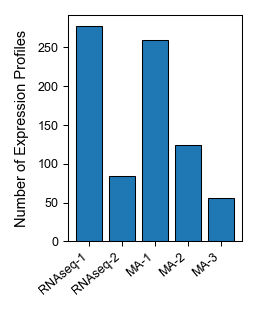

In [10]:
fig,ax = plt.subplots(figsize=(1.5,2))
plt.bar(range(5),[278,84,260,124,56],color='tab:blue')
plt.xticks(range(5),['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3'],rotation=40,ha='right')
plt.ylabel('Number of Expression Profiles') 

# Figure 3a - RBH Graph

In [11]:
# What is the maximum distance between i-modulons in the same dataset
for ds in datasets:
    print(((cos_dist(objs[ds].M,objs[ds].M)-np.eye(objs[ds].M.shape[1]))).max())

0.22235619835857207
0.09407806275507813
0.14150645352105426
0.04993435073196308
0.11058704787064352


../../scripts/rbh.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.dot(s1.T,s2)/np.sqrt((s1**2).sum())[:, np.newaxis]/np.sqrt((s2**2).sum())[np.newaxis,:]


In [12]:
rbh_dict = {}
for i in range(len(datasets)):
    for j in range(i+1,len(datasets)):
        rbh_dict[(i,j)] = rbh(objs[datasets[i]].M,objs[datasets[j]].M)

In [13]:
# Initialize graph
from graphviz import Digraph
dot = Digraph(engine='circo',graph_attr={'splines':'false'})

# Set colors
ds_colors = {'RNAseq-1':'#f47f72','RNAseq-2':'#a6d854','MA-1':'#fcf6b5','MA-2':'#bc80b7','MA-3':'#81b1d3'}
cat_shapes = {'regulatory':'circle','functional':'triangle','genomic':'star','uncharacterized':'square'}

# Initialize nodes
nodes = []
node_cats = []
links = []
        
# Create edges
for i,ds1 in enumerate(datasets):
    for j,ds2 in enumerate(datasets[i+1:]):
        edges = rbh_dict[(i,i+j+1)]
        for comp1,comp2,dist in edges:
            node1 = ds1+'_'+str(comp1)
            node2 = ds2+'_'+str(comp2)
            if dist < 0.7:
                if node1 not in nodes:
                    node_cats.append([ds1,comp1,DF_categories.loc[node1,'type'],DF_categories.loc[node1,'description']])
                    dot.node(node1,shape=cat_shapes[DF_categories.loc[node1,'type']],label='',width='.2',
                             height='.2',tooltip=str(DF_categories.loc[node1,'description']),
                             fillcolor=ds_colors[ds1],style='filled',
                             color='black',
                             penwidth='2')
                    nodes.append(node1)
                if node2 not in nodes:
                    node_cats.append([ds2,comp2,DF_categories.loc[node2,'type'],DF_categories.loc[node2,'description']])
                    dot.node(node2,shape=cat_shapes[DF_categories.loc[node2,'type']],label='',width='.2',
                             height='.2',tooltip=str(DF_categories.loc[node2,'description']),
                             fillcolor=ds_colors[ds2],style='filled',
                             color='black',penwidth='2')
                    nodes.append(node2)
                if dist < .7:
                    dot.edge(node1,node2,_attributes={'arrowhead':'none','color':get_edge_color(dist),
                                                      'penwidth':'{:.2f}'.format(11*(1-dist))})
                    
                    links.append((ds1,ds2,comp1,comp2,
                                  DF_categories.loc[node1,'type'],DF_categories.loc[node1,'description'],
                                  DF_categories.loc[node2,'type'],DF_categories.loc[node2,'description'],dist))

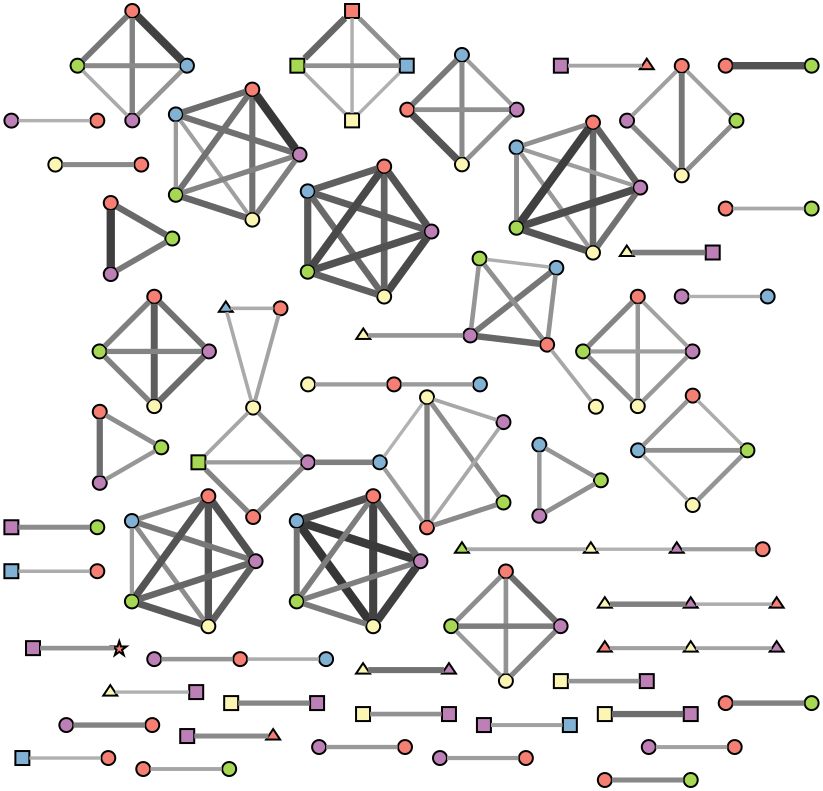

In [14]:
dot

## Legend

In [15]:
import matplotlib as mpl
def palplot(pal, size=1,labels=[]):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n))
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])

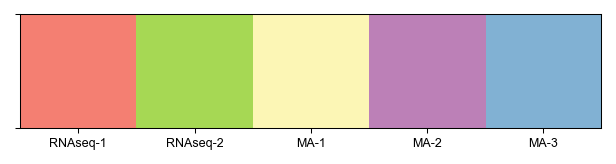

In [16]:
palplot(ds_colors.values(),labels=ds_colors.keys())

## Save links

In [17]:
DF_links = pd.DataFrame(links,columns=['ds1','ds2','comp1','comp2','type1','desc1','type2','desc2','dist'])
DF_nodes = pd.DataFrame(node_cats,columns=['ds','comp','type','desc'])

In [18]:
DF_links['ds1_code'] = [1 if x=='RNAseq-1' else
                        2 if x=='RNAseq-2' else
                        3 if x=='MA-1' else
                        4 if x=='MA-2' else
                        5  for x in DF_links.ds1]
DF_links['ds2_code'] = [1 if x=='RNAseq-1' else
                        2 if x=='RNAseq-2' else
                        3 if x=='MA-1' else
                        4 if x=='MA-2' else
                        5  for x in DF_links.ds2]

In [19]:
DF_links.sort_values(['ds1_code','ds2_code','comp1','comp2']).to_csv(os.path.join(DATA_DIR,'iModulons','rbh.csv'))

# Figure 3b

In [20]:
DF_nodes.type.value_counts()

regulatory         110
uncharacterized     23
functional          17
genomic              1
Name: type, dtype: int64

In [21]:
DF_nodes.type.value_counts()/len(DF_nodes)

regulatory         0.728477
uncharacterized    0.152318
functional         0.112583
genomic            0.006623
Name: type, dtype: float64

([<matplotlib.patches.Wedge at 0x7f4ec41ec3d0>,
 [Text(-0.7234863607446071, 0.8285936795658801, 'regulatory'),
  Text(0.37024214247975146, -1.0358188818186334, 'uncharacterized'),
  Text(1.0151693033217473, -0.42359330211092666, 'functional'),
  Text(1.099761936601309, -0.022884116826707088, 'genomic')])

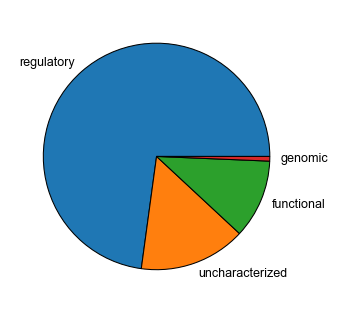

In [22]:
plt.pie(DF_nodes.type.value_counts(),labels=DF_nodes.type.value_counts().index)

# Figure 3c

In [23]:
print('Total links:',len(DF_links))
reg_linked = DF_links[(DF_links.type1=='regulatory') & (DF_links.type2=='regulatory')]
print('Links between two regulatory i-modulons: {} ({:.2f})'.format(len(reg_linked),len(reg_linked)/len(DF_links)))
same_reg = sum(reg_linked.desc1==reg_linked.desc2)
print('Links between reg i-mods with identical enrichment: {} ({:.2f})'.format(same_reg,(same_reg/len(reg_linked))))
print()
bio_linked = DF_links[(DF_links.type1=='functional') & (DF_links.type2=='functional')]
print('Links between two functional i-modulons: {} ({:.2f})'.format(len(bio_linked),len(bio_linked)/len(DF_links)))
same_go = sum(bio_linked.desc1==bio_linked.desc2)
print('Links between bio i-mods with identical enrichment: {} ({:.2f})'.format(same_go,(same_go/len(reg_linked))))

Total links: 166
Links between two regulatory i-modulons: 133 (0.80)
Links between reg i-mods with identical enrichment: 116 (0.87)

Links between two functional i-modulons: 7 (0.04)
Links between bio i-mods with identical enrichment: 6 (0.05)


In [24]:
link_pie = pd.Series({'Both Regulatory I-modulons (same regulator)':same_reg,
                      'Both Regulatory I-modulons (different regulator)':len(reg_linked)-same_reg,
                      'Both Functional I-modulons':len(bio_linked),
                      'Both Uncharacterized I-modulons': len(DF_links[(DF_links.type1=='uncharacterized') & 
                                                      (DF_links.type2=='uncharacterized')]),
                      'Different categories': len(DF_links[DF_links.type1 != DF_links.type2])})

([<matplotlib.patches.Wedge at 0x7f4ec41c02e0>,
 [Text(-0.9600562902302827, 0.536928225733447, 'Both Regulatory I-modulons (same regulator)'),
  Text(0.4648802045899223, -0.9969385113337894, 'Both Regulatory I-modulons (different regulator)'),
  Text(0.8551516939167209, -0.6918927520876073, 'Both Functional I-modulons'),
  Text(1.0371756434599886, -0.3664241867199254, 'Both Uncharacterized I-modulons'),
  Text(1.0872415889221165, 0.1670500742834658, 'Different categories')])

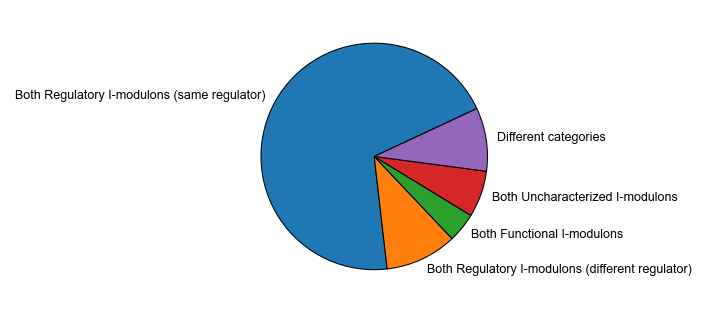

In [25]:
plt.pie(link_pie,labels=link_pie.index,startangle=25)

# Figure 3d - Heatmap

In [26]:
from collections import Counter

In [27]:
tot_mods = sum([len(objs[ds].M.columns) for ds in datasets])
print('Total i-modulons:',tot_mods)
print('I-modulons with links: {} ({:.2f})'.format(len(DF_nodes),len(DF_nodes)/len(DF_categories)))

Total i-modulons: 336
I-modulons with links: 151 (0.45)


<AxesSubplot:xlabel='type', ylabel='ds'>

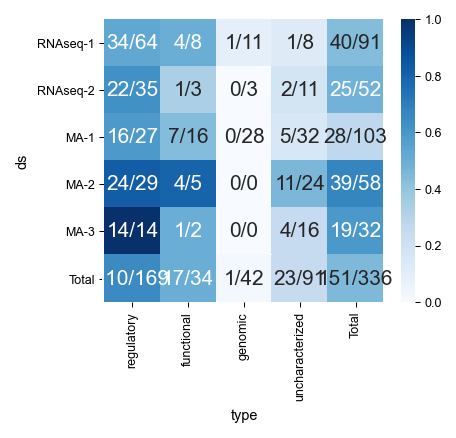

In [28]:
DF_types = DF_categories.groupby(['dataset','type']).count().component.unstack().fillna(0)
DF_types = DF_types.reindex(['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3'])
DF_types_linked = DF_nodes.groupby(['ds','type']).count().comp.unstack().fillna(0)
DF_types_linked = DF_types_linked.reindex(['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3'])

DF_types['Total'] = DF_types.sum(axis=1)
DF_types.loc['Total'] = DF_types.sum(axis=0)

DF_types_linked['Total'] = DF_types_linked.sum(axis=1)
DF_types_linked.loc['Total'] = DF_types_linked.sum(axis=0)

DF_text = pd.DataFrame()
for col in DF_types_linked:
    DF_text[col] = DF_types_linked[col].astype(int).astype(str).str.cat(DF_types[col].astype(int).astype(str),sep='/')
DF_text = DF_text[['regulatory','functional','genomic','uncharacterized','Total']]

type_grid = (DF_types_linked/DF_types).fillna(0)[['regulatory','functional','genomic','uncharacterized','Total']]

sns.heatmap(type_grid,cmap='Blues',annot=DF_text,fmt='s')

In [29]:
link_pie.sort_values()

Both Functional I-modulons                            7
Both Uncharacterized I-modulons                      11
Different categories                                 15
Both Regulatory I-modulons (different regulator)     17
Both Regulatory I-modulons (same regulator)         116
dtype: int64

# Supplementary Figure 3 - Full RBH graph

In [30]:
dot = Digraph(engine='circo',graph_attr={'splines':'false'})
        
# Create edges
for i,ds1 in enumerate(datasets):
    for j,ds2 in enumerate(datasets[i+1:]):
        edges = rbh_dict[(i,i+j+1)]
        for comp1,comp2,dist in edges:
            node1 = ds1+'_'+str(comp1)
            node2 = ds2+'_'+str(comp2)
            if node1 not in nodes:
                dot.node(node1,shape=cat_shapes[DF_categories.loc[node1,'type']],label='',width='.2',
                         height='.2',tooltip=str(DF_categories.loc[node1,'description']),
                         fillcolor=ds_colors[ds1],style='filled',
                         color='black',
                         penwidth='2')
            if node2 not in nodes:
                dot.node(node2,shape=cat_shapes[DF_categories.loc[node2,'type']],label='',width='.2',
                         height='.2',tooltip=str(DF_categories.loc[node2,'description']),
                         fillcolor=ds_colors[ds2],style='filled',
                         color='black',penwidth='2')
            if dist < .7:
                dot.edge(node1,node2,_attributes={'arrowhead':'none','color':get_edge_color(dist),
                                                  'penwidth':'{:.2f}'.format(11*(1-dist))})
            else:
                dot.edge(node1,node2,_attributes={'arrowtail':'normal','color':'gray','arrowhead':'none',
                                                  'penwidth':'{:.2f}'.format(11*(1-dist))})

In [31]:
#dot

# Supplementary Figure 8

In [34]:
for i,row in DF_links.iterrows():
    gene1 = objs[row.ds1].show_enriched(row.comp1).index
    gene2 = objs[row.ds2].show_enriched(row.comp2).index
    if min(len(set(gene1)),len(set(gene2))) == 0:
        DF_links.loc[i,'overlap'] = None
    else:
        intersect = set(gene1) & set(gene2)
        DF_links.loc[i,'overlap'] = len(set(gene1) & set(gene2))/min(len(set(gene1)),len(set(gene2)))

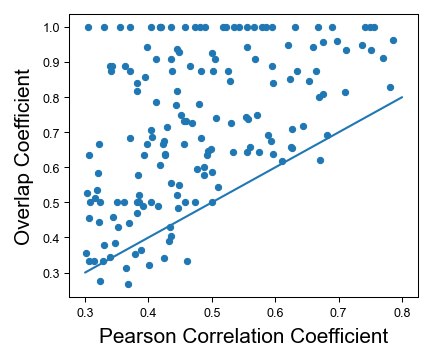

In [36]:
plt.scatter(1-DF_links.dist,DF_links.overlap)
stats.pearsonr(DF_links[DF_links.overlap.notnull()].dist,DF_links[DF_links.overlap.notnull()].overlap)
plt.ylabel('Overlap Coefficient',fontsize=10)
plt.xlabel('Pearson Correlation Coefficient',fontsize=10)
plt.plot([0.3,0.8],[0.3,0.8])